In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler,RobustScaler,OneHotEncoder

def load_titanic():
    data = pd.read_csv("titanic.csv")
    return data 

df = load_titanic()
df = df.drop("PassengerId",axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.columns = [col.lower() for col in df.columns]

In [3]:
def grab_col_names(df,cat_th=10,car_th=20):
    num_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    cat_cols = [col for col in df.columns if col not in num_cols]
    num_but_cat =  [col for col in num_cols if df[col].nunique()<cat_th]
    cat_but_car = [col for col in cat_cols if df[col].nunique()>car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"cat_cols = {len(cat_cols)}")
    print(f"num_cols ={len(num_cols)}")
    print(f"cat_but_car = {len(cat_but_car)}")
    print(f"num_but_cat={len(num_but_cat)}")
        
    return cat_cols, num_cols,cat_but_car

cat_cols, num_cols,cat_but_car=grab_col_names(df)

cat_cols = 6
num_cols =2
cat_but_car = 3
num_but_cat=4


In [4]:
df.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [5]:
df.embarked.value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [6]:
df.groupby("embarked")["survived"].mean()

embarked
C    0.553571
Q    0.389610
S    0.336957
Name: survived, dtype: float64

In [7]:
def missing_vs_target(df,target):
    na_cols = [col for col in df.columns if df[col].isnull().sum()>0]
    temp_df=df.copy()
    for col in na_cols:
        temp_df[col+"_NA_Flag"] = np.where(temp_df[col].isnull(),1,0)
    na_flags=[col for col in temp_df.columns if "_NA_" in col]
    for col in na_flags:
        print(pd.DataFrame({"Target_Mean":temp_df.groupby(col)[target].mean(),
                            "Count":temp_df.groupby(col)[target].count()}))
        print("-----------------------------------------------")

missing_vs_target(df,"survived")

             Target_Mean  Count
age_NA_Flag                    
0               0.406162    714
1               0.293785    177
-----------------------------------------------
               Target_Mean  Count
cabin_NA_Flag                    
0                 0.666667    204
1                 0.299854    687
-----------------------------------------------
                  Target_Mean  Count
embarked_NA_Flag                    
0                    0.382452    889
1                    1.000000      2
-----------------------------------------------


In [8]:
df["embarked"].fillna("C",inplace=True)

In [9]:
df["new_cabin"] = df["cabin"].notnull().astype(int)

In [10]:
df["new_cabin"] 

0      0
1      1
2      0
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: new_cabin, Length: 891, dtype: int32

In [11]:
encoders = {}  # Sütun isimlerini ve onlara karşılık gelen encoderları saklayacak bir sözlük oluştur

# Verideki her kategorik sütunu dönüştür
for col in ["sex","embarked"]:
    encoder = LabelEncoder()
    
    # Eğer sütun NaN değerler içeriyorsa
    if df[col].isna().any():
        # NaN değerlerini geçici değerle doldur
        df[col].fillna('NaN', inplace=True)
        
        # LabelEncoder uygula
        df[col] = encoder.fit_transform(df[col])
        
        # Geçici 'NaN' değerlerini np.nan ile tekrar doldur
        df[col].replace({encoder.transform(['NaN'])[0]: np.nan}, inplace=True)
    else:
        # NaN değerler yoksa doğrudan LabelEncoder uygula
        df[col] = encoder.fit_transform(df[col])

    # Bu encoder'ı sözlükte sakla
    encoders[col] = encoder

In [12]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,new_cabin
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,1
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,0


In [13]:
cat_cols, num_cols,cat_but_car=grab_col_names(df)

cat_cols = 7
num_cols =2
cat_but_car = 3
num_but_cat=7


In [14]:
df[cat_cols+num_cols]

,survived,pclass,sex,sibsp,parch,embarked,new_cabin,age,fare
0,0,3,1,1,0,2,0,22.0,7.2500
1,1,1,0,1,0,0,1,38.0,71.2833
2,1,3,0,0,0,2,0,26.0,7.9250
3,1,1,0,1,0,2,1,35.0,53.1000
4,0,3,1,0,0,2,0,35.0,8.0500
...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,2,0,27.0,13.0000
887,1,1,0,0,0,2,1,19.0,30.0000
888,0,3,0,1,2,2,0,NaN,23.4500
889,1,1,1,0,0,0,1,26.0,30.0000


In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
imp= IterativeImputer(
    estimator=XGBRegressor(n_estimators=200),
    max_iter=30,
    random_state=0
).set_output(transform="pandas")

a=imp.fit_transform(df[cat_cols+num_cols])

In [16]:
df.isnull().sum()

survived       0
pclass         0
name           0
sex            0
age          177
sibsp          0
parch          0
ticket         0
fare           0
cabin        687
embarked       0
new_cabin      0
dtype: int64

In [17]:
a

,survived,pclass,sex,sibsp,parch,embarked,new_cabin,age,fare
0,0.0,3.0,1.0,1.0,0.0,2.0,0.0,22.000000,7.2500
1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,38.000000,71.2833
2,1.0,3.0,0.0,0.0,0.0,2.0,0.0,26.000000,7.9250
3,1.0,1.0,0.0,1.0,0.0,2.0,1.0,35.000000,53.1000
4,0.0,3.0,1.0,0.0,0.0,2.0,0.0,35.000000,8.0500
...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,1.0,0.0,0.0,2.0,0.0,27.000000,13.0000
887,1.0,1.0,0.0,0.0,0.0,2.0,1.0,19.000000,30.0000
888,0.0,3.0,0.0,1.0,2.0,2.0,0.0,11.462794,23.4500
889,1.0,1.0,1.0,0.0,0.0,0.0,1.0,26.000000,30.0000


<Axes: ylabel='Density'>

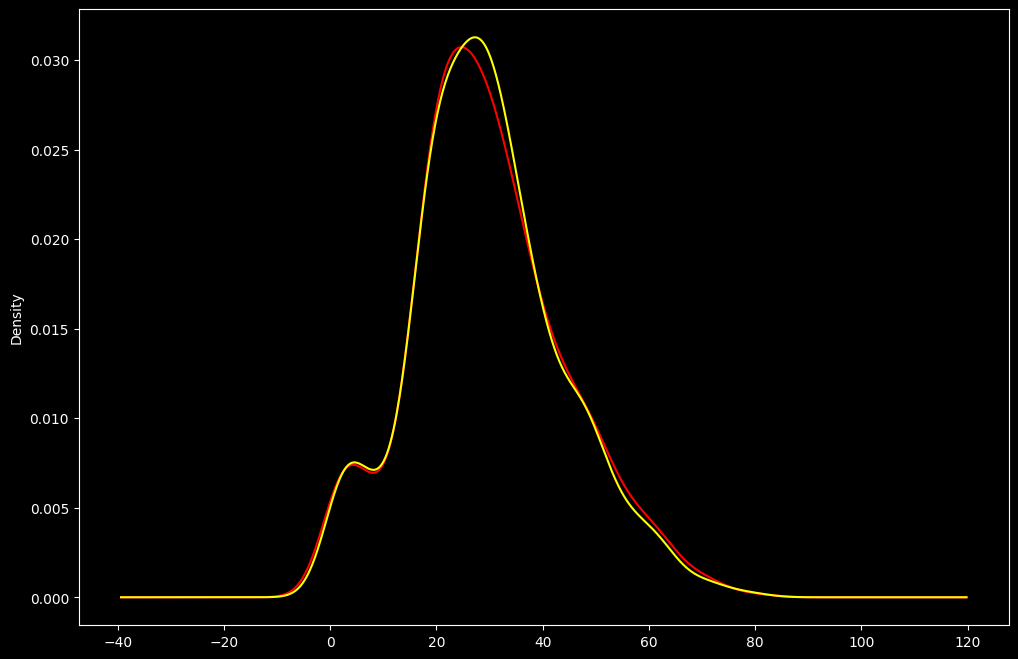

In [18]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

df["age"].plot(kind="kde",ax=ax,color="red")
a["age"].plot(kind="kde",ax=ax,color="yellow")

In [19]:
encoders

{'sex': LabelEncoder(), 'embarked': LabelEncoder()}

In [20]:
encoders["sex"].classes_

array(['female', 'male'], dtype=object)

In [21]:
encoders["embarked"].classes_

array(['C', 'Q', 'S'], dtype=object)

In [22]:
# Her bir kategorik sütunu orijinal değerlerine döndür
for col in ["sex","embarked"]:
    df[col] = encoders[col].inverse_transform(df[col].round().astype(int))

In [23]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,new_cabin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [24]:
df["embarked"].isnull().sum()

0

In [25]:
df["new_cabin"] = df["cabin"].notnull().astype(int)
df["name_letter_count"] = df["name"].str.len()
df["name_word_count"] = df["name"].apply(lambda x: len(str(x).split()))
df["new_name_dr"] = df["name"].apply(lambda x: len([a for a in x.split() if a.startswith("Dr.")]))
df["new_title"] = df["name"].str.extract(" ([A-Za-z]+)\.",expand = False)
df["new_family_size"] = df["sibsp"] + df["parch"] +1
df["new_age_pclass"] = df["age"] * df["pclass"]
df.loc[(df["sibsp"]+df["parch"])>0,"is_alone"] = 0
df.loc[(df["sibsp"]+df["parch"]==0),"is_alone"] = 1
df.loc[(df["age"]<18),"new_age_cat"] = "young"
df.loc[(df["age"]>=18) & (df["age"]<50),"new_age_cat"] = "mature"
df.loc[(df["age"]>=50),"new_age_cat"] = "senior"

df.loc[(df["sex"]=="male") & (df["age"]<=21),"new_sex_cat"] ="youngmale"
df.loc[(df["sex"]=="male") & (df["age"]>21) & (df["age"]<=50),"new_sex_cat"] = "maturemale"
df.loc[(df["sex"]=="male") & (df["age"]>50),"new_sex_cat"] = "seniormale"

df.loc[(df["sex"]=="female") & (df["age"]<=21),"new_sex_cat"] ="youngfemale"
df.loc[(df["sex"]=="female") & (df["age"]>21) & (df["age"]<=50),"new_sex_cat"] = "maturefemale"
df.loc[(df["sex"]=="female") & (df["age"]>50),"new_sex_cat"] = "seniorfemale"
df.shape

(891, 21)

In [26]:
def grab_col_names(df,cat_th=10,car_th=20):
    num_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    cat_cols = [col for col in df.columns if col not in num_cols]
    num_but_cat =  [col for col in num_cols if df[col].nunique()<cat_th]
    cat_but_car = [col for col in cat_cols if df[col].nunique()>car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"cat_cols = {len(cat_cols)}")
    print(f"num_cols ={len(num_cols)}")
    print(f"cat_but_car = {len(cat_but_car)}")
    print(f"num_but_cat={len(num_but_cat)}")
        
    return cat_cols, num_cols,cat_but_car

cat_cols, num_cols,cat_but_car=grab_col_names(df)

cat_cols = 14
num_cols =4
cat_but_car = 3
num_but_cat=9


In [27]:
cat_cols

['sex',
 'embarked',
 'new_title',
 'new_age_cat',
 'new_sex_cat',
 'survived',
 'pclass',
 'sibsp',
 'parch',
 'new_cabin',
 'name_word_count',
 'new_name_dr',
 'new_family_size',
 'is_alone']

In [28]:
def outliers(df,variable):
    q1 = df[variable].quantile(0.05)
    q3 = df[variable].quantile(0.95)
    iqr = q3-q1
    lower_lim = q1 - 1.5*iqr
    upper_lim = q3 + 1.5*iqr
    return lower_lim, upper_lim

def check_outliers(df, variable, index=False):
    lower_lim, upper_lim = outliers(df, variable)
    
    if index:
        return df.loc[(df[variable] < lower_lim) | (df[variable] > upper_lim)].index.tolist()
    
    else:
        if df.loc[(df[variable] < lower_lim) | (df[variable] > upper_lim)].any(axis=None):
            return True
        else:
            return False

In [29]:
for col in num_cols:
    print(col,check_outliers(df,col))

age False
fare True
name_letter_count False
new_age_pclass False


In [30]:
def replace_outliers(df,variable):
    lower_lim, upper_lim = outliers(df,variable)
    df[variable].clip(lower=lower_lim, upper=upper_lim,inplace=True)
replace_outliers(df,"fare")

In [31]:
for col in num_cols:
    print(col,check_outliers(df,col))

age False
fare False
name_letter_count False
new_age_pclass False


In [32]:
df.isnull().sum()

survived               0
pclass                 0
name                   0
sex                    0
age                  177
sibsp                  0
parch                  0
ticket                 0
fare                   0
cabin                687
embarked               0
new_cabin              0
name_letter_count      0
name_word_count        0
new_name_dr            0
new_title              0
new_family_size        0
new_age_pclass       177
is_alone               0
new_age_cat          177
new_sex_cat          177
dtype: int64

In [33]:
remove_cols=list(df[cat_but_car].columns)
remove_cols

['name', 'ticket', 'cabin']

In [34]:
def missing_values_table(df,na_name=False):
    na_cols = [col for col in df.columns if df[col].isnull().sum()>0]
    n_miss = df[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_cols].isnull().sum() / len(df)*100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss,np.round(ratio,2)],axis=1,keys=["n_miss","ratio"])
    
    return na_cols,missing_df

na_cols,missing_df = missing_values_table(df)
missing_df

,n_miss,ratio
cabin,687,77.10
age,177,19.87
new_age_pclass,177,19.87
new_age_cat,177,19.87
new_sex_cat,177,19.87


In [35]:
df.groupby("new_sex_cat")["age"].mean()

new_sex_cat
maturefemale    32.900000
maturemale      32.846154
seniorfemale    56.470588
seniormale      59.531915
youngfemale     12.642857
youngmale       14.393083
Name: age, dtype: float64

In [36]:
df.drop(remove_cols,axis=1,inplace=True)

In [42]:
df[["new_sex_cat","age"]]

,new_sex_cat,age
0,maturemale,22.0
1,maturefemale,38.0
2,maturefemale,26.0
3,maturefemale,35.0
4,maturemale,35.0
...,...,...
886,maturemale,27.0
887,youngfemale,19.0
888,NaN,NaN
889,maturemale,26.0


In [43]:
df["age"].fillna(df.groupby(["sex","new_sex_cat","parch","new_title","is_alone",])["age"].transform("mean"))

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: age, Length: 891, dtype: float64

In [38]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,new_cabin,name_letter_count,name_word_count,new_name_dr,new_title,new_family_size,new_age_pclass,is_alone,new_age_cat,new_sex_cat
0,0,3,male,22.0,1,0,7.2500,S,0,23,4,0,Mr,2,66.0,0.0,mature,maturemale
1,1,1,female,38.0,1,0,71.2833,C,1,51,7,0,Mrs,2,38.0,0.0,mature,maturefemale
2,1,3,female,26.0,0,0,7.9250,S,0,22,3,0,Miss,1,78.0,1.0,mature,maturefemale
3,1,1,female,35.0,1,0,53.1000,S,1,44,7,0,Mrs,2,35.0,0.0,mature,maturefemale
4,0,3,male,35.0,0,0,8.0500,S,0,24,4,0,Mr,1,105.0,1.0,mature,maturemale


In [39]:
b=df["age"].fillna(df.groupby(["sex","pclass","parch","new_title","is_alone",])["age"].transform("mean"))

In [40]:
b.isnull().sum()

0

<Axes: ylabel='Density'>

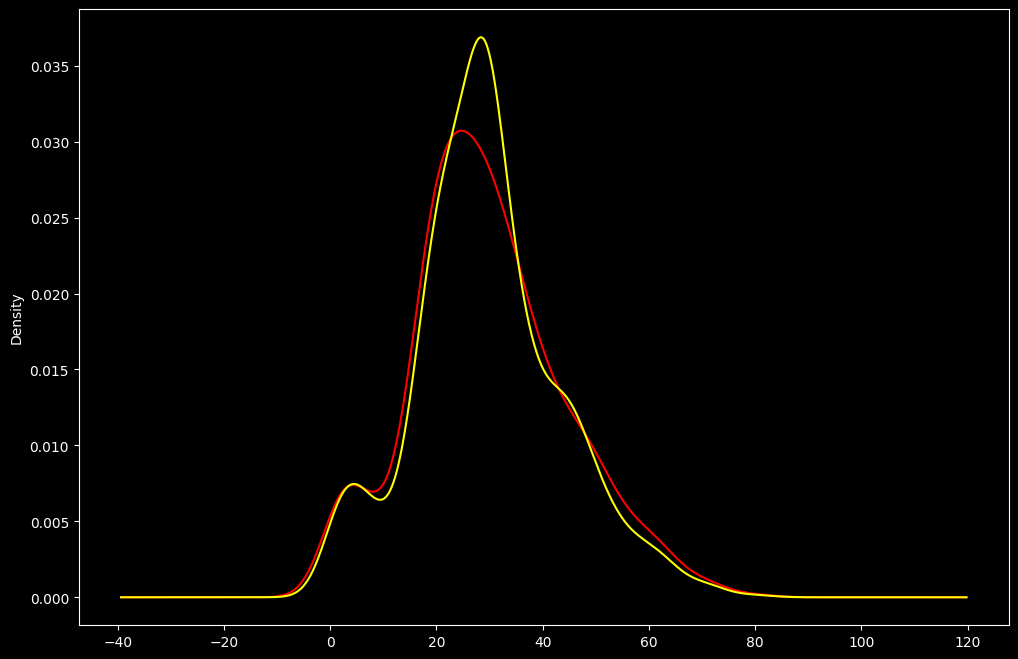

In [41]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

df["age"].plot(kind="kde",ax=ax,color="red")
b.plot(kind="kde",ax=ax,color="yellow")